## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [60]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [61]:
#loading the data
df = pd.read_csv('ab_data.csv');
#confirming
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [62]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [63]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [64]:
df.query('converted == 1').user_id.count()/294478

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [65]:
#we use query method to get the rows that contains  new_page but no treatment and vice versa
df.query('(group =="treatment" and landing_page != "new_page") or (group !="treatment" and landing_page == "new_page")').user_id.count() 

3893

f. Do any of the rows have missing values?

In [66]:
#we find here that there is no row with missing values
df.isnull().count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [67]:
# quering rows that have a treatment group and new_page landing_page or rows that have a control group and old_page landing_page
df2=df.query('(group =="treatment" and landing_page == "new_page") or (group =="control" and landing_page == "old_page")')

In [68]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [69]:
df2.user_id.nunique()

290584

In [70]:
#here is an indicator that there is duplicated user_id
df2.shape

(290585, 5)

b. There is one **user_id** repeated in **df2**.  What is it?

In [71]:
#here we get the user_id of the duplicated row
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [72]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [73]:
# drop the duplicated row
df2 = df2.drop_duplicates(subset='user_id');

In [74]:
#confirming
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


In [75]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [76]:
#percentage of converted rows
df2[df2['converted'] == 1].user_id.count()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [77]:
#percentage of converted rows from control group
df2.query('group == "control" and converted == 1').shape[0]/df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [78]:
#percentage of converted rows from treatment group
df2.query('group == "treatment" and converted == 1').shape[0]/df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [79]:
#percentage of new_page landing_page
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here :**

Well , there isn't a sufficient evidence to say that the new treatment page leads to more conversions ,since the probability of conversion for treatment group (0.1188)is a bit lower than control group(0.1203).Although the percentage is higher for control we can't be sure that control group will leads to more.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here :**

$H_{0}$: $𝑝_{𝑛𝑒𝑤}$ <= $p_{old}$

$H_{1}$: $𝑝_{new}$ > $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [80]:
#we have assumed as required that 𝑝𝑛𝑒𝑤  and 𝑝𝑜𝑙𝑑 are equal in success rate.
𝑝_𝑛𝑒𝑤 =df2.query('converted == 1').converted.shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [81]:
#the null hypothesis says there is no difference between conversion rates of old and new page
𝑝_𝑜𝑙𝑑 =df2.query('converted == 1').converted.shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [82]:
#number or new_page rows
𝑛_𝑛𝑒𝑤 = df2.query('landing_page == "new_page"').shape[0]
𝑛_𝑛𝑒𝑤

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [83]:
#number od old_page rows
𝑛_𝑜𝑙𝑑 =df2.query('landing_page == "old_page"').shape[0]
𝑛_𝑜𝑙𝑑 

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [84]:
#here we use numpy.random.choice function that will simulate 𝑛_𝑛𝑒𝑤  transactions with a conversion rate of 𝑝_𝑛𝑒𝑤 under the nulland store these n_𝑛𝑒𝑤 1's and 0's in new_page_converted
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
#getting the mean
new_page_converted.mean()



0.1199917417934072

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [85]:
#here we use numpy.random.choice function that will simulate 𝑛_old  transactions with a conversion rate of 𝑝_old under the nulland store these n_old 1's and 0's in new_page_converted
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
#getting the mean
old_page_converted.mean()

0.11889257540922671

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [87]:
# beacuse they have differnet size we will have their means
new_page_converted.mean() - old_page_converted.mean()

0.0010991663841804916

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [88]:
#an array to store the difference in mean of p_new & p_old
p_diffs=[]
#10000 iterations
for _ in range (10000):
    simulate_new = np.random.choice([0 , 1], size= n_new, p=[1 - p_new, p_new])
    simulate_old = np.random.choice([0 , 1], size= n_old, p=[1 - p_old , p_old])
    p_diffs.append(simulate_new.mean()-simulate_old.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

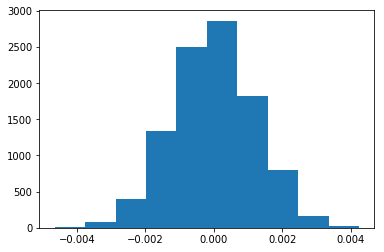

In [89]:
#first convert it to numpy array
p_diffs=np.array(p_diffs)

#ploting
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [90]:
# display the difference of the observations
observed_diff =df2.query('group == "treatment"').converted.mean()-df2.query('group == "control"').converted.mean()
observed_diff

-0.0015782389853555567

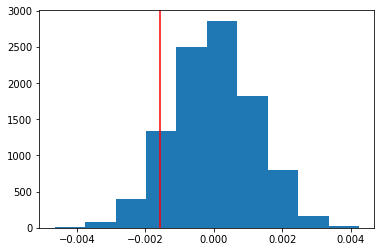

In [91]:
plt.hist(p_diffs);
plt.axvline(observed_diff,color='red');

In [92]:
#the proportion of p_diffs weather its greater than the actual difference observed in ab_data.csv
(p_diffs > observed_diff).mean()

0.90680000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here:**

The value that has been computed in part j is p-value.p-value here represent the observation when null hypothesis is true.From what I computed we can say that we fail to reject null hypothesis because p-value is large enough to still use the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [93]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == "1"').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == "1"').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
print ("number of convert_old " , convert_old)
print ("number of convert_new " , convert_new)
print ("number of n_old " , n_old)
print ("number of n_new " , n_new)


number of convert_old  17489
number of convert_new  17264
number of n_old  145274
number of n_new  145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [94]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(" z_score : ",z_score)
print("p_value", p_value)

 z_score :  -1.31092419842
p_value 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here :**
For part one :
Z-score is measured in terms of standard deviations from the mean which is observed_diff .
For second part :
yes , I agree with the findings in part j and k both have a p-value equal to 0.9


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here :**

Since converted columns has two possible values 0 and 1 (binary) , its better to use (Logistic regression).

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [124]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [125]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [126]:
#here when i execute result.summary there is an error that says
#AttributeError: module 'scipy.stats' has no attribute 'chisqprob'
#I went to stackOverFlow the find a solution and was to use summary2()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-14 23:39 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
uk             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
us             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here :**
The p-value is equal to almost(.19) in the logistic regression .In part|| null and alternative hypthesis , old_page and new_page have the same convert rate and that not how it works in logistic regression model

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here :**
Sometimes its good idea consider other factors to add into your regression model , but is not always its depends on the dataset.old generations prefer to have a simple website where kids likes photo and colors and for them  website become more attractive ,from that point generation  might be considered.Adding factors more might increase/decrease confidence intervals.To me I see that adding additional terms into regression model might be risky because when combining variables together the impact might not apper.On the other hand, testing them separately might show their impact.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [127]:
countries_df = pd.read_csv('./countries.csv')
df_merged = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [128]:
df_merged['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [129]:
#adding dummies
df_merged[['CA', 'UK', 'US']] =  pd.get_dummies (df_merged['country'])
#confirming
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [130]:
log_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
result = log_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-14 23:39 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

In [103]:
df_merged.shape

(290584, 10)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [131]:
# Create new columns to show from which country the userconverte
df_merged['US_page'] = df_merged['US'] * df_merged['ab_page']
df_merged['UK_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US,US_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [133]:
log_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK', 'US_page', 'UK_page']])
result = log_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-14 23:42 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

We fail to reject the null because none of the variables have significant p-value.There is no solid evidence to say that countr play a role in determining weather or not user convert.Lastly , we don't have sufficient evidence to suggest that the new page will have more conversions than the old page conversions.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [134]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0